# Cleaning and Preprocessing Data for Machine Learning

In [119]:
import warnings
warnings.simplefilter('ignore')

# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import date, datetime
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle

Kaggle TMDB Competition Test Data 

In [120]:
# Read the csv files into a pandas DataFrame
# Our goal is to predict the movie revenue without adding additional data to the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#test.head(2)
train.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


## Assign weights to Cast by actor on # "appearances"

In [121]:
# Import Cast Table with Counts of Appearances
file = "Cast_Data.csv"
castData = pd.read_csv(file)
castData.rename(columns = {"Num":"numtimesDS"}, inplace = True)
castData.sort_values(by='numtimesDS', ascending=False, inplace = True)
# calculation to create the actor wt
castData['actorWt'] = castData['numtimesDS']/castData['numtimesDS'].max().astype(np.float64)
castData.head()

,Key_ID,Cast_Name,numtimesDS,actorWt
0,65827,KeithDavid,8,1.000
2,8534,KathyBates,7,0.875
3,2039,BrendanGleeson,7,0.875
4,2955,ChrisCooper,7,0.875
1,18999,JKSimmons,7,0.875


## Assign weights to Production Company by # "appearances"

In [122]:
# Import Production Company Table with Counts of Appearances
file = "ProdCo_Data.csv"
prodcoData = pd.read_csv(file)
prodcoData.rename(columns = {"Prod_Co":"numtimesDS"}, inplace = True)
prodcoData.sort_values(by='numtimesDS', ascending=False, inplace = True)

prodcoData['prodcoWt'] = prodcoData['numtimesDS']/prodcoData['numtimesDS'].max().astype(np.float64)
prodcoData.head()

,Prod_Co_keyID,numtimesDS,keyID,prodcoWt
0,Warner Bros.,132,6194,1.000000
1,Metro-Goldwyn-Mayer (MGM),44,8411,0.333333
2,Relativity Media,42,7295,0.318182
3,Canal+,41,5358,0.310606
4,Touchstone Pictures,35,9195,0.265152


## Assign weights to Keyword by # "appearances"

In [123]:
# Import Cast Table with Counts of Appearances
file = "Keyword_Data.csv"
keywordData = pd.read_csv(file)
keywordData.rename(columns = {"# of Uses in DS":"numtimesDS"}, inplace = True)
keywordData.sort_values(by='numtimesDS', ascending=False, inplace = True)

keywordData['keywordWt'] = keywordData['numtimesDS']/keywordData['numtimesDS'].max().astype(np.float64)
keywordData.head()

,Keyword ID,Keyword,numtimesDS,keywordWt
0,187056,woman director,174,1.000000
1,10183,independent film,155,0.890805
2,179431,duringcreditsstinger,134,0.770115
3,9826,murder,123,0.706897
4,818,based on novel,111,0.637931


## Assign weights to Crew by # "appearances"

In [124]:
# Import Crew Table with Counts of Appearances
file = "Crew_Data_clean.csv"
crewData = pd.read_csv(file)
crewData.rename(columns = {"Num":"numtimesDS"}, inplace = True)
crewData.sort_values(by='numtimesDS', ascending=False, inplace = True)

crewData['crewWt'] = crewData['numtimesDS']/crewData['numtimesDS'].max().astype(np.float64)
crewData.head()

,Crew_ID,Crew_Name,numtimesDS,crewWt
0,638,Michael Mann,8,1.000
1,1213,James Newton Howard,8,1.000
2,1352969,Wylie Stateman,7,0.875
3,6410,Francine Maisler,7,0.875
4,3965,Deborah Aquila,7,0.875


In [125]:
# In order to apply weights to the field with JSON data, we first flatten, then convert to list, then iterate to produce a wt. 
# We are assuming that bigger "stars" appear in the dataset more times. 
#https://www.kaggle.com/rajuspartan/exploratory-data-analysis-with-reusable-functions
#Flatening JSON columns
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d
train["castList"] = train.cast.map(lambda x: sorted([d['id'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test["castList"] = test.cast.map(lambda x: sorted([d['id'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

train["keywordList"] = train.Keywords.map(lambda x: sorted([d['id'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test["keywordList"] = test.Keywords.map(lambda x: sorted([d['id'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

train["prodcoList"] = train.production_companies.map(lambda x: sorted([d['id'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test["prodcoList"] = test.production_companies.map(lambda x: sorted([d['id'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

train["crewList"] = train.crew.map(lambda x: sorted([d['id'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test["crewList"] = test.crew.map(lambda x: sorted([d['id'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

In [126]:
train.head(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,tagline,title,Keywords,cast,crew,revenue,castList,keywordList,prodcoList,crewList
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,"2224,3036,36801,52997,54729,54812,59256,64342,...","4379,9663,11830,179431","4,60,8411","3227,6117,13168,22219,23486,52997,57431,57822,..."


In [127]:
test.head(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,status,tagline,title,Keywords,cast,crew,castList,keywordList,prodcoList,crewList
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...","73044,82140,108721,110045,111767,111768,111779","11451,11551",,"25761,65429"


# Cast, Keyword, Production Company Grading

In [128]:
#Convert string to list, separate on commas
train['castList'] = train['castList'].apply(lambda x: x[1:-1].split(','))
test['castList'] = test['castList'].apply(lambda x: x[1:-1].split(','))

train['keywordList'] = train['keywordList'].apply(lambda x: x[1:-1].split(','))
test['keywordList'] = test['keywordList'].apply(lambda x: x[1:-1].split(','))

train['prodcoList'] = train['prodcoList'].apply(lambda x: x[1:-1].split(','))
test['prodcoList'] = test['prodcoList'].apply(lambda x: x[1:-1].split(','))

train['crewList'] = train['crewList'].apply(lambda x: x[1:-1].split(','))
test['crewList'] = test['crewList'].apply(lambda x: x[1:-1].split(','))

In [129]:
#create sum of weights column
def weight(data):
    wt = 0
    for row in data:
        for x in row:
            wt = wt + int(x)
            
    return wt

train['castWt'] = train['castList'].apply(weight)
test['castWt'] = test['castList'].apply(weight)

train['keywordWt'] = train['keywordList'].apply(weight)
test['keywordWt'] = test['keywordList'].apply(weight)  

train['prodcoWt'] = train['prodcoList'].apply(weight)
test['prodcoWt'] = test['prodcoList'].apply(weight)

train['crewWt'] = train['crewList'].apply(weight)
test['crewWt'] = test['crewList'].apply(weight)

In [130]:
#Add columns for Team weights
train['teamWt'] = train['castWt']+train['crewWt']+train['prodcoWt']
test['teamWt'] = test['castWt']+test['crewWt']+test['prodcoWt']

In [131]:
train.head(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,revenue,castList,keywordList,prodcoList,crewList,castWt,keywordWt,prodcoWt,crewWt,teamWt
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,12314651,"[224, 3036, 36801, 52997, 54729, 54812, 59256,...","[379, 9663, 11830, 17943]","[, 60, 841]","[227, 6117, 13168, 22219, 23486, 52997, 57431,...",597,80,19,1930,2546


In [132]:
test.head(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,crew,castList,keywordList,prodcoList,crewList,castWt,keywordWt,prodcoWt,crewWt,teamWt
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'credit_id': '52fe44e7c3a368484e03d683', 'de...","[3044, 82140, 108721, 110045, 111767, 111768, ...","[1451, 1155]",[],"[5761, 6542]",120,23,0,36,156


# Create count features

In [133]:

#https://www.kaggle.com/jiegeng94/machine-learning-beginner-tutorial
def proc_json_len(string):
    try:
        data = eval(string)
        return len(data)
    except:
        return 0

train['count_genre'] = train.genres.apply(proc_json_len)
train['count_country'] = train.production_countries.apply(proc_json_len)
train['count_company'] = train.production_companies.apply(proc_json_len)
train['count_splang'] = train.spoken_languages.apply(proc_json_len)
train['count_cast'] = train.cast.apply(proc_json_len)
train['count_crew'] = train.crew.apply(proc_json_len)
train['count_staff'] = train.count_cast + train.count_crew
train['count_keyword'] = train.Keywords.apply(proc_json_len)
    
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,crewWt,teamWt,count_genre,count_country,count_company,count_splang,count_cast,count_crew,count_staff,count_keyword
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,1930,2546,1,1,3,1,24,72,96,4
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,158,543,4,1,1,1,20,9,29,4
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,1669,2977,1,1,3,1,51,64,115,12
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,51,202,2,1,0,2,7,3,10,7
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,47,127,2,1,0,1,4,2,6,0


In [134]:
test['count_genre'] = test.genres.apply(proc_json_len)
test['count_country'] = test.production_countries.apply(proc_json_len)
test['count_company'] = test.production_companies.apply(proc_json_len)
test['count_splang'] = test.spoken_languages.apply(proc_json_len)
test['count_cast'] = test.cast.apply(proc_json_len)
test['count_crew'] = test.crew.apply(proc_json_len)
test['count_staff'] = test.count_cast + test.count_crew
test['count_keyword'] = test.Keywords.apply(proc_json_len)
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,crewWt,teamWt,count_genre,count_country,count_company,count_splang,count_cast,count_crew,count_staff,count_keyword
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,36,156,4,2,0,2,7,2,9,2
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,197,387,2,1,1,1,10,8,18,8
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,157,329,2,1,3,1,9,10,19,4
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,1784,2433,3,2,3,3,23,69,92,15
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,328,412,2,1,0,1,4,14,18,4


In [135]:
#Collection or not?
train['belongs_to_collection'] = train['belongs_to_collection'].notna()
test['belongs_to_collection'] = test['belongs_to_collection'].notna()

#Create a Year Column
train['date'] = pd.to_datetime(train['release_date'])
train['year'] = train['date'].dt.year

test['date'] = pd.to_datetime(test['release_date'])
test['year'] = test['date'].dt.year

#Create a Month Column
train['month'] = train['date'].dt.month
test['month'] = test['date'].dt.month

test.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,count_country,count_company,count_splang,count_cast,count_crew,count_staff,count_keyword,date,year,month
0,3001,True,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,2,0,2,7,2,9,2,2007-07-14,2007.0,7.0
1,3002,False,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,1,1,1,10,8,18,8,2058-05-19,2058.0,5.0


In [136]:
##GENRES, Spoken Languages

In [137]:
new_genres_train = pd.DataFrame(train['genres'])
new_genres_test = pd.DataFrame(test['genres'])
new_genres_test.head()

,genres
0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '..."
1,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na..."
2,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
3,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n..."
4,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na..."


In [138]:
new_splang_train = pd.DataFrame(train['spoken_languages'])
new_splang_test = pd.DataFrame(test['spoken_languages'])
new_splang_test.head()

,spoken_languages
0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso..."
1,"[{'iso_639_1': 'en', 'name': 'English'}]"
2,"[{'iso_639_1': 'en', 'name': 'English'}]"
3,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is..."
4,"[{'iso_639_1': 'en', 'name': 'English'}]"


In [139]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d
#https://www.kaggle.com/rajuspartan/exploratory-data-analysis-with-reusable-functions
#Flatening JSON columns
new_genres_train.genres = new_genres_train.genres.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
new_genres_test.genres = new_genres_test.genres.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

new_splang_train.spoken_languages = new_splang_train.spoken_languages.map(lambda x: sorted([d['iso_639_1'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
new_splang_test.spoken_languages = new_splang_test.spoken_languages.map(lambda x: sorted([d['iso_639_1'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

In [140]:
new_genres_test.head()

,genres
0,"Adventure,Animation,Family,Fantasy"
1,"Horror,Science Fiction"
2,"Comedy,Romance"
3,"Drama,Mystery,War"
4,"Documentary,History"


In [141]:
new_splang_train.head()

,spoken_languages
0,en
1,en
2,en
3,"en,hi"
4,ko


In [142]:
#Used this approach from Stack Overflow
#https://stackoverflow.com/questions/50394099/separate-columns-based-on-genre
#featurize the genre column
new_genres_train = new_genres_train['genres'].str.get_dummies(',')
new_genres_test = new_genres_test['genres'].str.get_dummies(',')
print(new_genres_test)

      Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  Family  \
0          0          1          1       0      0            0      0       1   
1          0          0          0       0      0            0      0       0   
2          0          0          0       1      0            0      0       0   
3          0          0          0       0      0            0      1       0   
4          0          0          0       0      0            1      0       0   
5          0          0          0       1      0            0      1       0   
6          0          0          0       1      0            0      1       0   
7          0          0          1       0      0            0      0       1   
8          0          0          0       0      0            0      1       0   
9          0          0          1       1      0            0      0       1   
10         0          0          0       1      0            0      0       0   
11         0          0     

In [143]:
#featurize the spoken language column
# Is english in the spoken language?
def proc_json_len2(string):
        if ('en' in string):
            return 1
        else:
            return 0
  
new_splang_train['inEnglish'] = new_splang_train['spoken_languages'].apply(proc_json_len2)
new_splang_test['inEnglish'] = new_splang_test['spoken_languages'].apply(proc_json_len2)


In [144]:
new_splang_train.columns
new_splang_train.head()

,spoken_languages,inEnglish
0,en,1
1,en,1
2,en,1
3,"en,hi",1
4,ko,0


In [145]:
#add genres back to data (join)
train = pd.concat([train, new_genres_train], axis = 1, sort = False)
test = pd.concat([test, new_genres_test], axis = 1, sort = False)
train.head()


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,True,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,0,0
1,2,True,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,1,0,0,0,0,0
2,3,False,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,0,0
3,4,False,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,0,0,0,0,0,0,1,0,0
4,5,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,0,0,0,0,0,0,1,0,0


In [146]:
#add spoken languages back to data (join)
train = pd.concat([train, new_splang_train], axis = 1, sort = False)
test = pd.concat([test, new_splang_test], axis = 1, sort = False)
train.head()


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,spoken_languages,inEnglish
0,1,True,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,en,1
1,2,True,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,1,0,0,0,0,0,en,1
2,3,False,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,en,1
3,4,False,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,0,0,0,0,1,0,0,"en,hi",1
4,5,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,0,0,0,0,1,0,0,ko,0


In [147]:
test.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'castList',
       'keywordList', 'prodcoList', 'crewList', 'castWt', 'keywordWt',
       'prodcoWt', 'crewWt', 'teamWt', 'count_genre', 'count_country',
       'count_company', 'count_splang', 'count_cast', 'count_crew',
       'count_staff', 'count_keyword', 'date', 'year', 'month', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'Thriller', 'War', 'Western',
       'spoken_languages', 'inEnglish'],
      dtype='object')

In [148]:
#Select subset of columns
train = train[['id','belongs_to_collection','budget', 'original_language', 'popularity', 'status','year', 'month', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western', 'count_genre',
       'count_country', 'count_company', 'count_splang', 'count_cast',
       'count_crew', 'count_staff', 'count_keyword', "castWt",'prodcoWt','keywordWt', 'crewWt','teamWt','inEnglish', "revenue"]]
test = test[['id','belongs_to_collection','budget', 'original_language', 'popularity', 'status','year', 'month', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'War', 'Western', 'count_genre',
       'count_country', 'count_company', 'count_splang', 'count_cast',
       'count_crew', 'count_staff', 'count_keyword', "castWt",'prodcoWt','keywordWt', 'crewWt','teamWt','inEnglish']]

test.head()

,id,belongs_to_collection,budget,original_language,popularity,status,year,month,Action,Adventure,...,count_cast,count_crew,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish
0,3001,True,0,ja,3.851534,Released,2007.0,7.0,0,1,...,7,2,9,2,120,0,23,36,156,1
1,3002,False,88000,en,3.559789,Released,2058.0,5.0,0,0,...,10,8,18,8,185,5,161,197,387,1
2,3003,False,0,en,8.085194,Released,1997.0,5.0,0,0,...,9,10,19,4,128,44,68,157,329,1
3,3004,False,6800000,fr,8.596012,Released,2010.0,9.0,0,0,...,23,69,92,15,611,38,263,1784,2433,1
4,3005,False,2000000,en,3.217680,Released,2005.0,2.0,0,0,...,4,14,18,4,84,0,56,328,412,1


In [149]:
train.head()

,id,belongs_to_collection,budget,original_language,popularity,status,year,month,Action,Adventure,...,count_crew,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish,revenue
0,1,True,14000000,en,6.575393,Released,2015,2,0,0,...,72,96,4,597,19,80,1930,2546,1,12314651
1,2,True,40000000,en,8.248895,Released,2004,8,0,0,...,9,29,4,385,0,53,158,543,1,95149435
2,3,False,3300000,en,64.299990,Released,2014,10,0,0,...,64,115,12,1270,38,234,1669,2977,1,13092000
3,4,False,1200000,hi,3.174936,Released,2012,3,0,0,...,3,10,7,151,0,115,51,202,1,16000000
4,5,False,0,ko,1.148070,Released,2009,2,1,0,...,2,6,0,80,0,0,47,127,0,3923970


In [150]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'original_language',
       'popularity', 'status', 'year', 'month', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'count_genre', 'count_country', 'count_company', 'count_splang',
       'count_cast', 'count_crew', 'count_staff', 'count_keyword', 'castWt',
       'prodcoWt', 'keywordWt', 'crewWt', 'teamWt', 'inEnglish', 'revenue'],
      dtype='object')

In [151]:
test.columns

Index(['id', 'belongs_to_collection', 'budget', 'original_language',
       'popularity', 'status', 'year', 'month', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'Thriller', 'War', 'Western',
       'count_genre', 'count_country', 'count_company', 'count_splang',
       'count_cast', 'count_crew', 'count_staff', 'count_keyword', 'castWt',
       'prodcoWt', 'keywordWt', 'crewWt', 'teamWt', 'inEnglish'],
      dtype='object')

Machine Learning algorithms work with numerical data. We have to convert our strings into meaningful numbers. We often use Integer, One-hot, or Binary Encoding. Sklearn provides a preprocessing libarary for all of these standard preprocessing techniques. Pandas also provides a `get_dummies` method that is useful to generate binary encoded data from a Data Frame. 

## Dummy Encoding (Binary Encoded Data)

Dummy Encoding transforms each categorical feature into new columns with a 1 (True) or 0 (False) encoding to represent if that categorical label was present or not in the original row. 

Pandas provides a shortcut to create Binary Encoded data.

In [152]:
data = train.copy()
data2 = test.copy()

In [153]:
data_binary_encoded = pd.get_dummies(data, columns=["belongs_to_collection", "status"])
data2_binary_encoded = pd.get_dummies(data2, columns=["belongs_to_collection", "status"])

data2_binary_encoded.head()

,id,budget,original_language,popularity,year,month,Action,Adventure,Animation,Comedy,...,prodcoWt,keywordWt,crewWt,teamWt,inEnglish,belongs_to_collection_False,belongs_to_collection_True,status_Post Production,status_Released,status_Rumored
0,3001,0,ja,3.851534,2007.0,7.0,0,1,1,0,...,0,23,36,156,1,0,1,0,1,0
1,3002,88000,en,3.559789,2058.0,5.0,0,0,0,0,...,5,161,197,387,1,1,0,0,1,0
2,3003,0,en,8.085194,1997.0,5.0,0,0,0,1,...,44,68,157,329,1,1,0,0,1,0
3,3004,6800000,fr,8.596012,2010.0,9.0,0,0,0,0,...,38,263,1784,2433,1,1,0,0,1,0
4,3005,2000000,en,3.217680,2005.0,2.0,0,0,0,0,...,0,56,328,412,1,1,0,0,1,0


In [154]:
#Select subset of columns
train = data_binary_encoded[['id','belongs_to_collection_True', 'budget', 'original_language', 'popularity', 'status_Released', 'year', 'month', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western', 'count_genre',
       'count_country', 'count_company', 'count_splang', 'count_cast',
       'count_crew', 'count_staff', 'count_keyword', "castWt",'prodcoWt','keywordWt', 'crewWt','teamWt','inEnglish', 'revenue']]
train.head()

,id,belongs_to_collection_True,budget,original_language,popularity,status_Released,year,month,Action,Adventure,...,count_crew,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish,revenue
0,1,1,14000000,en,6.575393,1,2015,2,0,0,...,72,96,4,597,19,80,1930,2546,1,12314651
1,2,1,40000000,en,8.248895,1,2004,8,0,0,...,9,29,4,385,0,53,158,543,1,95149435
2,3,0,3300000,en,64.299990,1,2014,10,0,0,...,64,115,12,1270,38,234,1669,2977,1,13092000
3,4,0,1200000,hi,3.174936,1,2012,3,0,0,...,3,10,7,151,0,115,51,202,1,16000000
4,5,0,0,ko,1.148070,1,2009,2,1,0,...,2,6,0,80,0,0,47,127,0,3923970


In [155]:
test = data2_binary_encoded[['id','belongs_to_collection_True', 'budget', 'original_language', 'popularity', 'status_Released', 'year', 'month', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction','Thriller', 'War', 'Western', 'count_genre',
       'count_country', 'count_company', 'count_splang', 'count_cast',
       'count_crew', 'count_staff', 'count_keyword', "castWt", 'prodcoWt','keywordWt', 'crewWt','teamWt','inEnglish']]
test.head()

,id,belongs_to_collection_True,budget,original_language,popularity,status_Released,year,month,Action,Adventure,...,count_cast,count_crew,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish
0,3001,1,0,ja,3.851534,1,2007.0,7.0,0,1,...,7,2,9,2,120,0,23,36,156,1
1,3002,0,88000,en,3.559789,1,2058.0,5.0,0,0,...,10,8,18,8,185,5,161,197,387,1
2,3003,0,0,en,8.085194,1,1997.0,5.0,0,0,...,9,10,19,4,128,44,68,157,329,1
3,3004,0,6800000,fr,8.596012,1,2010.0,9.0,0,0,...,23,69,92,15,611,38,263,1784,2433,1
4,3005,0,2000000,en,3.217680,1,2005.0,2.0,0,0,...,4,14,18,4,84,0,56,328,412,1


## Factorize to map each categorical item in a column to a value

In [156]:
train['language_enc'] = pd.factorize(train['original_language'])[0]
train.head()

,id,belongs_to_collection_True,budget,original_language,popularity,status_Released,year,month,Action,Adventure,...,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish,revenue,language_enc
0,1,1,14000000,en,6.575393,1,2015,2,0,0,...,96,4,597,19,80,1930,2546,1,12314651,0
1,2,1,40000000,en,8.248895,1,2004,8,0,0,...,29,4,385,0,53,158,543,1,95149435,0
2,3,0,3300000,en,64.299990,1,2014,10,0,0,...,115,12,1270,38,234,1669,2977,1,13092000,0
3,4,0,1200000,hi,3.174936,1,2012,3,0,0,...,10,7,151,0,115,51,202,1,16000000,1
4,5,0,0,ko,1.148070,1,2009,2,1,0,...,6,0,80,0,0,47,127,0,3923970,2


In [157]:
test['language_enc'] = pd.factorize(test['original_language'])[0]
test.head()

,id,belongs_to_collection_True,budget,original_language,popularity,status_Released,year,month,Action,Adventure,...,count_crew,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish,language_enc
0,3001,1,0,ja,3.851534,1,2007.0,7.0,0,1,...,2,9,2,120,0,23,36,156,1,0
1,3002,0,88000,en,3.559789,1,2058.0,5.0,0,0,...,8,18,8,185,5,161,197,387,1,1
2,3003,0,0,en,8.085194,1,1997.0,5.0,0,0,...,10,19,4,128,44,68,157,329,1,1
3,3004,0,6800000,fr,8.596012,1,2010.0,9.0,0,0,...,69,92,15,611,38,263,1784,2433,1,2
4,3005,0,2000000,en,3.217680,1,2005.0,2.0,0,0,...,14,18,4,84,0,56,328,412,1,1


In [158]:
#This is just a list of all of the languages listed
catenc = pd.factorize(train['original_language'])
catenc


(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 Index(['en', 'hi', 'ko', 'sr', 'fr', 'it', 'nl', 'zh', 'es', 'cs', 'ta', 'cn',
        'ru', 'tr', 'ja', 'fa', 'sv', 'de', 'te', 'pt', 'mr', 'da', 'fi', 'el',
        'ur', 'he', 'no', 'ar', 'nb', 'ro', 'vi', 'pl', 'hu', 'ml', 'bn', 'id'],
       dtype='object'))


# FINAL CLEANUP FOR NaN

In [159]:
#Select subset of columns
train = train[['id','belongs_to_collection_True', 'budget', 'language_enc', 'popularity', 'status_Released','year', 'month', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western', 'count_genre',
       'count_country', 'count_company', 'count_splang', 'count_cast',
       'count_crew', 'count_staff', 'count_keyword', "castWt",'prodcoWt','keywordWt', 'crewWt','teamWt','inEnglish',"revenue"]]
train.head()

,id,belongs_to_collection_True,budget,language_enc,popularity,status_Released,year,month,Action,Adventure,...,count_crew,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish,revenue
0,1,1,14000000,0,6.575393,1,2015,2,0,0,...,72,96,4,597,19,80,1930,2546,1,12314651
1,2,1,40000000,0,8.248895,1,2004,8,0,0,...,9,29,4,385,0,53,158,543,1,95149435
2,3,0,3300000,0,64.299990,1,2014,10,0,0,...,64,115,12,1270,38,234,1669,2977,1,13092000
3,4,0,1200000,1,3.174936,1,2012,3,0,0,...,3,10,7,151,0,115,51,202,1,16000000
4,5,0,0,2,1.148070,1,2009,2,1,0,...,2,6,0,80,0,0,47,127,0,3923970


In [160]:
#testID = test[['id']]
test = test[['id','belongs_to_collection_True', 'budget', 'language_enc', 'popularity', 'status_Released','year', 'month', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'War', 'Western', 'count_genre',
       'count_country', 'count_company', 'count_splang', 'count_cast',
       'count_crew', 'count_staff', 'count_keyword', "castWt",'prodcoWt','keywordWt', 'crewWt','teamWt','inEnglish']]
test.head()

,id,belongs_to_collection_True,budget,language_enc,popularity,status_Released,year,month,Action,Adventure,...,count_cast,count_crew,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish
0,3001,1,0,0,3.851534,1,2007.0,7.0,0,1,...,7,2,9,2,120,0,23,36,156,1
1,3002,0,88000,1,3.559789,1,2058.0,5.0,0,0,...,10,8,18,8,185,5,161,197,387,1
2,3003,0,0,1,8.085194,1,1997.0,5.0,0,0,...,9,10,19,4,128,44,68,157,329,1
3,3004,0,6800000,2,8.596012,1,2010.0,9.0,0,0,...,23,69,92,15,611,38,263,1784,2433,1
4,3005,0,2000000,1,3.217680,1,2005.0,2.0,0,0,...,4,14,18,4,84,0,56,328,412,1


In [161]:
df1_NaN = test[test.isnull().any(axis=1)]
print(df1_NaN)

       id  belongs_to_collection_True  budget  language_enc  popularity  \
828  3829                           0       0             1    0.009057   

     status_Released  year  month  Action  Adventure    ...      count_cast  \
828                0   NaN    NaN       0          0    ...               0   

     count_crew  count_staff  count_keyword  castWt  prodcoWt  keywordWt  \
828           0            0              0       0         0          0   

     crewWt  teamWt  inEnglish  
828       0       0          0  

[1 rows x 41 columns]


In [162]:
test.fillna(0,inplace = True)
df1_NaN = test[test.isnull().any(axis=1)]
print(df1_NaN)

Empty DataFrame
Columns: [id, belongs_to_collection_True, budget, language_enc, popularity, status_Released, year, month, Action, Adventure, Animation, Comedy, Crime, Documentary, Drama, Family, Fantasy, Foreign, History, Horror, Music, Mystery, Romance, Science Fiction, Thriller, War, Western, count_genre, count_country, count_company, count_splang, count_cast, count_crew, count_staff, count_keyword, castWt, prodcoWt, keywordWt, crewWt, teamWt, inEnglish]
Index: []

[0 rows x 41 columns]


In [163]:
train.head()

,id,belongs_to_collection_True,budget,language_enc,popularity,status_Released,year,month,Action,Adventure,...,count_crew,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish,revenue
0,1,1,14000000,0,6.575393,1,2015,2,0,0,...,72,96,4,597,19,80,1930,2546,1,12314651
1,2,1,40000000,0,8.248895,1,2004,8,0,0,...,9,29,4,385,0,53,158,543,1,95149435
2,3,0,3300000,0,64.299990,1,2014,10,0,0,...,64,115,12,1270,38,234,1669,2977,1,13092000
3,4,0,1200000,1,3.174936,1,2012,3,0,0,...,3,10,7,151,0,115,51,202,1,16000000
4,5,0,0,2,1.148070,1,2009,2,1,0,...,2,6,0,80,0,0,47,127,0,3923970


In [62]:
#save csv of master transformations of ml train and test data
train.to_csv("master_train.csv")
test.to_csv("master_test.csv")


In [164]:
X = train[['id','belongs_to_collection_True', 'budget', 'language_enc', 'popularity','year', 'month', 'count_genre',
       'count_country', 'count_company', 'count_splang', 'count_cast',
       'count_crew', 'count_staff', 'count_keyword', "castWt",'prodcoWt','keywordWt', 'crewWt','teamWt','inEnglish']]
y = train['revenue'].values.reshape(-1,1)
print(X.shape, y.shape)

(3000, 21) (3000, 1)


In [165]:
test = test[['id','belongs_to_collection_True', 'budget', 'language_enc', 'popularity','year', 'month', 'count_genre',
       'count_country', 'count_company', 'count_splang', 'count_cast',
       'count_crew', 'count_staff', 'count_keyword', "castWt",'prodcoWt','keywordWt', 'crewWt','teamWt','inEnglish']]

In [166]:
test.shape

(4398, 21)

In [167]:
train.dtypes

id                              int64
belongs_to_collection_True      uint8
budget                          int64
language_enc                    int64
popularity                    float64
status_Released                 uint8
year                            int64
month                           int64
Action                          int64
Adventure                       int64
Animation                       int64
Comedy                          int64
Crime                           int64
Documentary                     int64
Drama                           int64
Family                          int64
Fantasy                         int64
Foreign                         int64
History                         int64
Horror                          int64
Music                           int64
Mystery                         int64
Romance                         int64
Science Fiction                 int64
Thriller                        int64
War                             int64
Western     

In [168]:
#look at top values only
train2 = train[['belongs_to_collection_True', 'budget', 'popularity', 'year', 'month',  'count_cast', 'prodcoWt', 'teamWt','revenue']]
train2.head()

,belongs_to_collection_True,budget,popularity,year,month,count_cast,prodcoWt,teamWt,revenue
0,1,14000000,6.575393,2015,2,24,19,2546,12314651
1,1,40000000,8.248895,2004,8,20,0,543,95149435
2,0,3300000,64.299990,2014,10,51,38,2977,13092000
3,0,1200000,3.174936,2012,3,7,0,202,16000000
4,0,0,1.148070,2009,2,4,0,127,3923970


In [169]:
#apply scalers
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train2_scaled = scaler.fit_transform(train2)
train2_scaled

array([[ 1.99170465, -0.23045256, -0.15599768, ..., -0.43788158,
         1.54438008, -0.39569077],
       [ 1.99170465,  0.47187212, -0.01771439, ..., -0.94397989,
        -0.54291059,  0.20670283],
       [-0.50208247, -0.51948618,  4.61384865, ...,  0.06821672,
         1.99351752, -0.39003771],
       ...,
       [-0.50208247,  1.14718432,  0.49736238, ..., -0.01169353,
        -0.55958391,  0.1653044 ],
       [-0.50208247,  0.5258971 ,  0.6000891 , ..., -0.33133457,
         1.92057176,  0.76531155],
       [-0.50208247,  0.33680969,  0.16929745, ...,  1.87951592,
         1.03271772,  0.11171093]])

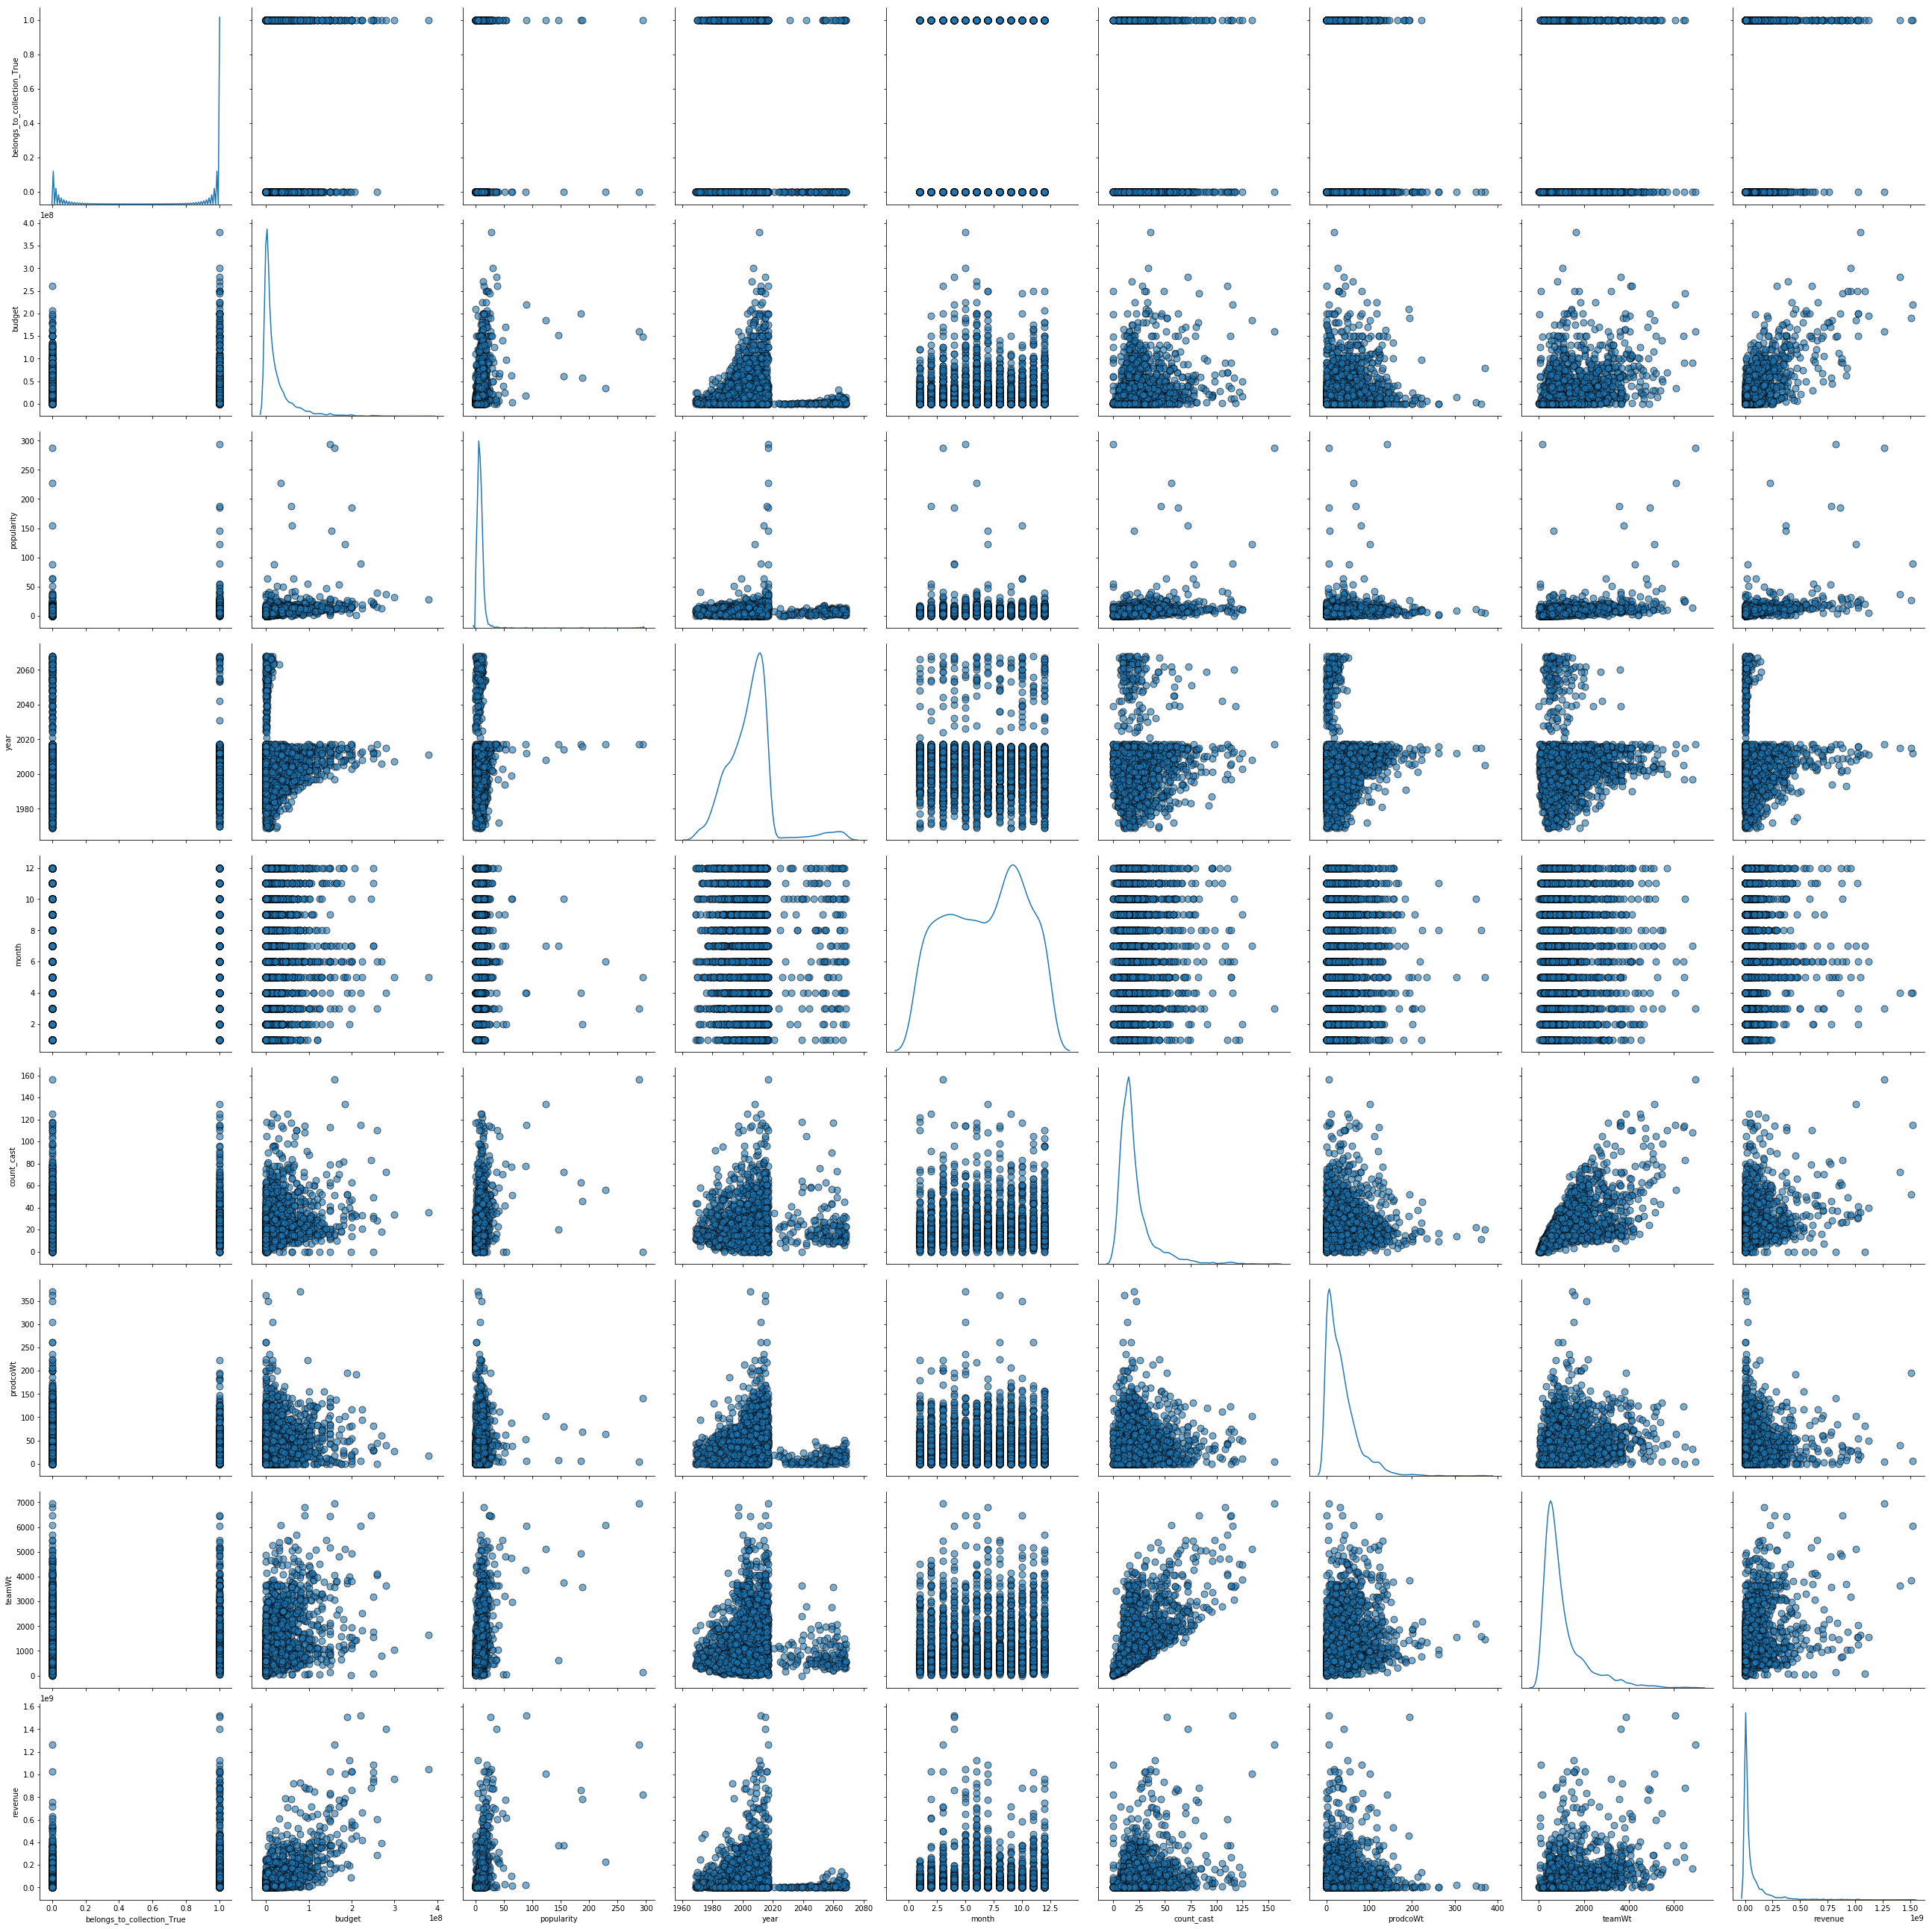

In [170]:
#explore datasets
import seaborn as sns
pairplots = sns.pairplot(train2, diag_kind = 'kde', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)
plt.savefig('outputs/pairplots.png')

## Can we predict the film revenue from this dataset?

In [171]:
X.head()

,id,belongs_to_collection_True,budget,language_enc,popularity,year,month,count_genre,count_country,count_company,...,count_cast,count_crew,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish
0,1,1,14000000,0,6.575393,2015,2,1,1,3,...,24,72,96,4,597,19,80,1930,2546,1
1,2,1,40000000,0,8.248895,2004,8,4,1,1,...,20,9,29,4,385,0,53,158,543,1
2,3,0,3300000,0,64.299990,2014,10,1,1,3,...,51,64,115,12,1270,38,234,1669,2977,1
3,4,0,1200000,1,3.174936,2012,3,2,1,0,...,7,3,10,7,151,0,115,51,202,1
4,5,0,0,2,1.148070,2009,2,2,1,0,...,4,2,6,0,80,0,0,47,127,0


In [172]:
print(X.shape, y.shape)

(3000, 21) (3000, 1)


In [173]:
test.head()

,id,belongs_to_collection_True,budget,language_enc,popularity,year,month,count_genre,count_country,count_company,...,count_cast,count_crew,count_staff,count_keyword,castWt,prodcoWt,keywordWt,crewWt,teamWt,inEnglish
0,3001,1,0,0,3.851534,2007.0,7.0,4,2,0,...,7,2,9,2,120,0,23,36,156,1
1,3002,0,88000,1,3.559789,2058.0,5.0,2,1,1,...,10,8,18,8,185,5,161,197,387,1
2,3003,0,0,1,8.085194,1997.0,5.0,2,1,3,...,9,10,19,4,128,44,68,157,329,1
3,3004,0,6800000,2,8.596012,2010.0,9.0,3,2,3,...,23,69,92,15,611,38,263,1784,2433,1
4,3005,0,2000000,1,3.217680,2005.0,2.0,2,1,0,...,4,14,18,4,84,0,56,328,412,1


In [174]:
test.shape

(4398, 21)

# TEST / TRAIN SPLIT OF ORIGINAL TRAIN Dataset

In [175]:
# Use train_test_split to create training and testing data from our "train" dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [176]:
print(X_train.shape, y_train.shape)

(2250, 21) (2250, 1)


In [177]:
print(X_test.shape, y_test.shape)

(750, 21) (750, 1)


# LINEAR REGRESSION - No Scaling

#This is the default state of the model
class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)[source]

In [112]:
from sklearn.linear_model import LinearRegression
#create the linear regression object
model = LinearRegression(fit_intercept = True)
#train the model
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
print(f"Training Score: {training_score}")

Training Score: 0.6590908183987398


In [113]:
# Plot the Residuals for the Training and Testing data
### BEGIN SOLUTION
#make predictions using the testing set
prediction = model.predict(X_test)

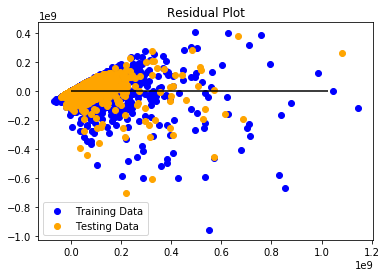

MSE: 6482058638469479.0, R2: 0.6140834832247379


In [114]:
#plot residuals
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(prediction, prediction - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

MSE = mean_squared_error(y_test, prediction)
r2 = model.score(X_test, y_test)
### END SOLUTION
print(f"MSE: {MSE}, R2: {r2}")

In [115]:
model.predict(X_train).shape

(2250, 1)

In [116]:
y_train.shape

(2250, 1)

In [117]:
#Check to make sure data is clean for projection
#are any values NaN or Infinite?
#np.any(np.isnan(test))
#np.all(np.isfinite(test))

## Polynomial Regression - No Scaler

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
poly.fit(X_train, y_train)
training_score = poly.score(X_train, y_train)
print(f"Training Score: {training_score}")

Training Score: 0.8012823685628331


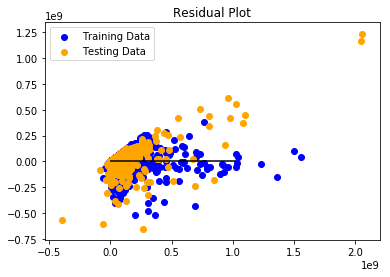

MSE: 1.2568897120199394e+16, R2: 0.251696834776048


In [119]:
# Plot the Residuals for the Training and Testing data
### BEGIN SOLUTION
#make predictions using the testing set
prediction = poly.predict(X_test)

#plot residuals
plt.scatter(poly.predict(X_train), poly.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(prediction, prediction - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

MSE = mean_squared_error(y_test, prediction)
r2 = poly.score(X_test, y_test)
### END SOLUTION
print(f"MSE: {MSE}, R2: {r2}")

## Gradient Boosting Regressor - No Scaler

class sklearn.ensemble.GradientBoostingRegressor(loss=’ls’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)[source]¶

In [72]:
# Note:  Changing max depth from 4 to 6 increased the score from .87 to .94 BUT decreased our kaggle overall score.
#Note: Increasing the learning rate from .01 to .1 increased score to .97 BUT decreased our kaggle overall score.
# How to we call out the MSE?
import numpy as np
import matplotlib.pyplot as plt
# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': .01, 'loss': 'ls'} 
clf = ensemble.GradientBoostingRegressor(**params)
predictions2 = clf.fit(X_train,y_train)
training_score = clf.score(X_train, y_train)
print(f"Training Score: {training_score}")

# on 3/10 changed n_estimators fron 500 to 100 and learning rate from .01 to .1
#the training score went up but r2 dropped slightly for test
#max depth makes a big difference.  Originally set at 4.  will try submitting with both 2 and 10

Training Score: 0.8804464132736559


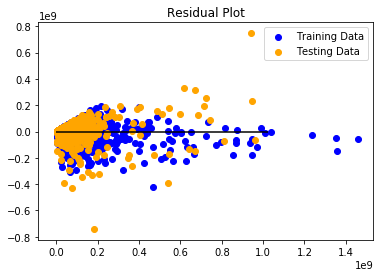

MSE: 6243500338586031.0, R2: 0.6282863149597786


In [73]:
# Plot the Residuals for the Training and Testing data
### BEGIN SOLUTION
predictions2 = np.expand_dims(clf.predict(X_test), axis = 1)
plt.scatter((np.expand_dims(clf.predict(X_train), axis = 1)), (np.expand_dims(clf.predict(X_train), axis = 1)) - y_train, c="blue", label="Training Data")
plt.scatter(predictions2, predictions2 - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

MSE = mean_squared_error(y_test, predictions2)
r2 = clf.score(X_test, y_test)
print(f"MSE: {MSE}, R2: {r2}")

## Scaling and Normalization

The final step that we need to perform is scaling and normalization. Many algorithms will perform better with a normalized or scaled dataset. You may not see a difference with the Sklearn LinearRegression model, but other models that use gradient descent need normalization to help the algorithms converge to a local optima.

Sklearn provides a variety of scaling and normalization options. The two most common are minmax and StandardScaler. Use StandardScaler when you don't know anything about your data.

### StandardScaler

Now, we fit our StandardScaler model to our training data. We can apply this StandardScaler model to any future data. Note that we use this fit/transform approach so that we isolate our testing data from the training data that we use to fit our model. Otherwise, we might bias our model to the testing data. 

In [178]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

StandardScaler applies a Guassian distribution to our data where the mean is 0 and the standard deviation is 1. We can see the difference in the following plots.

### Quantile Transformer

Like scalers, QuantileTransformer puts all features into the same, known range or distribution. However, by performing a rank transformation, it smooths out unusual distributions and is less influenced by outliers than scaling methods. It does, however, distort correlations and distances within and across features.

In [ ]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=1000, random_state=0)

In [ ]:
X_train_scaled = qt.fit_transform(X_train)
X_test_scaled = qt.fit_transform(X_test)
y_train_scaled = qt.fit_transform(y_train)
y_test_scaled = qt.fit_transform(y_test)

### Robust Scaler

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
X_scaler = RobustScaler().fit(X_train)
y_scaler = RobustScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Power Transformer

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
X_scaler = PowerTransformer().fit(X_train)
y_scaler = PowerTransformer().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Min-Max Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Linear Regression

In [ ]:
# Create a LinearRegression model and fit it to the scaled training data
from sklearn.linear_model import LinearRegression
model2 = LinearRegression()
model2.fit(X_train_scaled, y_train_scaled)

In [ ]:
# Make predictions using the X_test_scaled data
# Plot y_test_scaled vs y_test_scaled
# Scatter plot y_test_scaled vs predictions
predictions = model2.predict(X_test_scaled)
plt.scatter(model2.predict(X_train_scaled), model2.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(predictions, predictions - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [ ]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model2.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

# Ridge Model

In [ ]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

# ElasticNet model

In [ ]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

# GradientBoostingRegressor

In [179]:
# Note:  Changing max depth from 4 to 6 increased the score from .87 to .94 BUT decreased our kaggle overall score.
#Note: Increasing the learning rate from .01 to .1 increased score to .97 BUT decreased our kaggle overall score.
import numpy as np
import matplotlib.pyplot as plt
# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'} 
gbr = ensemble.GradientBoostingRegressor(**params)
predictions2 = gbr.fit(X_train_scaled,y_train_scaled)
training_score = gbr.score(X_train_scaled, y_train_scaled)
print(f"Training Score: {training_score}")

Training Score: 0.8910283052962551


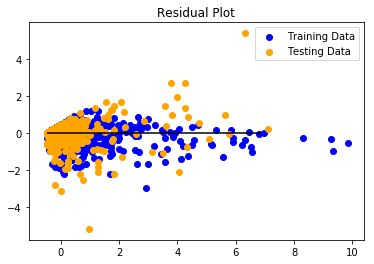

MSE: 0.3040707532053769, R2: 0.6450384343400017


In [180]:
# Plot the Residuals for the Training and Testing data
### BEGIN SOLUTION

predictions2 = np.expand_dims(gbr.predict(X_test_scaled), axis = 1)
plt.scatter((np.expand_dims(gbr.predict(X_train_scaled), axis = 1)), (np.expand_dims(gbr.predict(X_train_scaled), axis = 1)) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(predictions2, predictions2 - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

MSE = mean_squared_error(y_test_scaled, predictions2)
r2 = gbr.score(X_test_scaled, y_test_scaled)
print(f"MSE: {MSE}, R2: {r2}")

In [183]:
feature_names = X_train.columns
sorted(zip(gbr.feature_importances_, feature_names), reverse=True)

[(0.643745139002066, 'budget'),
 (0.11162970556722977, 'popularity'),
 (0.049514591385380946, 'belongs_to_collection_True'),
 (0.048138390113692205, 'count_cast'),
 (0.024651100934362565, 'month'),
 (0.018032278507845338, 'prodcoWt'),
 (0.016056309952009865, 'id'),
 (0.011691626490050308, 'year'),
 (0.010619304613935381, 'count_genre'),
 (0.010264651818779435, 'teamWt'),
 (0.010175420993479683, 'keywordWt'),
 (0.009864911716670128, 'count_staff'),
 (0.009218596394842562, 'crewWt'),
 (0.008300624957109958, 'count_keyword'),
 (0.006528873096622343, 'castWt'),
 (0.004663476161031673, 'count_crew'),
 (0.002638832467604388, 'count_splang'),
 (0.0017042472731519265, 'inEnglish'),
 (0.0012601222614133862, 'count_country'),
 (0.001219255058101386, 'count_company'),
 (8.254123462087398e-05, 'language_enc')]

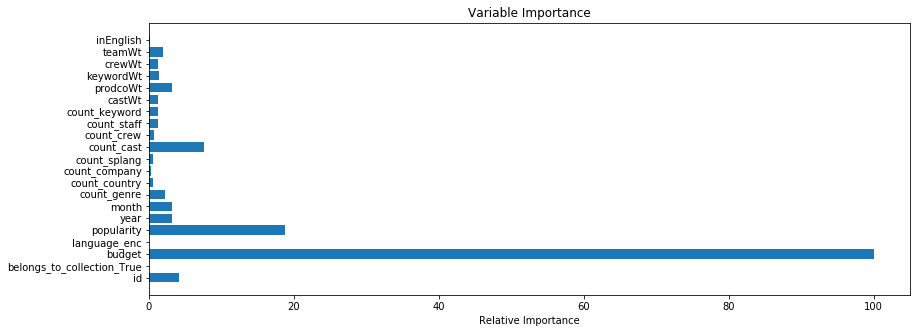

In [182]:
feature_names = X_train.columns
sorted(zip(gbr.feature_importances_, feature_names), reverse=True)
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
#sorted_idx = np.argsort(feature_importance)
#pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, feature_names)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('outputs/varImport.png')
plt.show()

# Random Forest Regressor

class sklearn.ensemble.RandomForestRegressor(n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False)[source]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf = rf.fit(X_train_scaled, y_train_scaled)
rf.score(X_train_scaled, y_train_scaled)

In [ ]:
# Plot the Residuals for the Training and Testing data
### BEGIN SOLUTION

predictions3 = np.expand_dims(rf.predict(X_test_scaled), axis = 1)
plt.scatter((np.expand_dims(rf.predict(X_train_scaled), axis = 1)), (np.expand_dims(rf.predict(X_train_scaled), axis = 1)) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(predictions3, predictions3 - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

MSE = mean_squared_error(y_test_scaled, predictions3)
r2 = rf.score(X_test_scaled, y_test_scaled)
print(f"MSE: {MSE}, R2: {r2}")

In [ ]:
feature_names = X_train.columns
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

## LASSO

class sklearn.linear_model.Lasso(alpha=1.0, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection=’cyclic’)

In [ ]:
from sklearn.linear_model import Lasso
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train_scaled, y_train_scaled)
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
print(clf.coef_)
print(clf.intercept_)  
clf.score(X_train_scaled, y_train_scaled)

In [ ]:
# Plot the Residuals for the Training and Testing data
### BEGIN SOLUTION

predictions3 = np.expand_dims(rf.predict(X_test_scaled), axis = 1)
plt.scatter((np.expand_dims(rf.predict(X_train_scaled), axis = 1)), (np.expand_dims(rf.predict(X_train_scaled), axis = 1)) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(predictions3, predictions3 - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

MSE = mean_squared_error(y_test_scaled, predictions3)
r2 = rf.score(X_test_scaled, y_test_scaled)
print(f"MSE: {MSE}, R2: {r2}")

# OUPUT

In [ ]:
#Be sure to run the training model on the full X (train) before running the predictions for test

#Make New Predictions
gbr_predictions = pd.DataFrame(gbr.predict(test), columns = ['revenue'])
output = pd.concat([testID['id'], gbr_predictions], axis=1)

#rf_predictions = pd.DataFrame(rf.predict(test), columns = ['revenue'])
#output = pd.concat([testID['id'], rf_predictions], axis=1)

In [ ]:
output.head()

In [ ]:
output.to_csv("outputs/output_" + str(date.today()) + "_4" + ".csv", index=False)